# **Fastai - lesson 5**
---
## *Linear model and neural net from scratch*

In [69]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [70]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth = 140)
torch.set_printoptions(linewidth = 140, sci_mode = False, edgeitems = 7)
pd.set_option('display.width', 140)

In [71]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [72]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [73]:
#Substituindo valores NaN pela moda (valor mais vezes repetido)
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [74]:
df.fillna(modes, inplace = True)

In [75]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [76]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


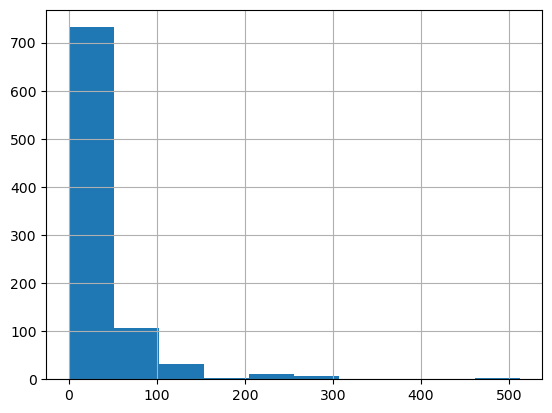

In [77]:
df['Fare'].hist();

In [78]:
df['LogFare'] = np.log(df['Fare']+1)

<Axes: >

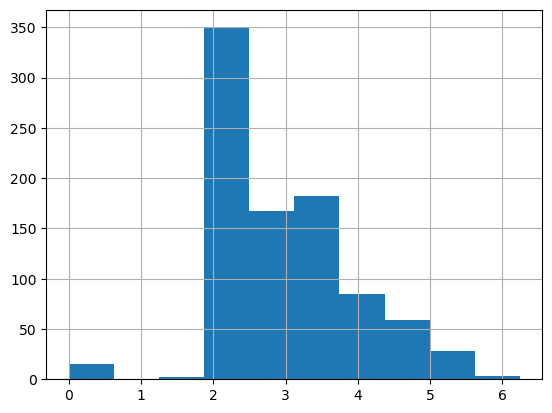

In [79]:
df['LogFare'].hist()

In [80]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [81]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [82]:
df = pd.get_dummies(df, columns = ['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [83]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


In [84]:
from torch import tensor
t_dep = tensor(df.Survived)

In [85]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype = torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [86]:
t_indep.shape

torch.Size([891, 12])

In [87]:
len(t_indep.shape)

2

In [88]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [89]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [90]:
vals, indices = t_indep.max(dim = 0)
t_indep = t_indep / vals

In [91]:
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [92]:
t_indep = t_indep / vals

In [93]:
preds = (t_indep * coeffs).sum(axis = 1)

In [94]:
preds[:10]

tensor([ 0.3675, -0.2917,  0.3131,  0.5119,  0.3638,  0.2121,  0.5599,  0.3742,  0.3246, -0.4591])

In [95]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5415)

In [96]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [97]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [98]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5415, grad_fn=<MeanBackward0>)

In [99]:
loss.backward()

In [100]:
coeffs.grad

tensor([ 0.0003,  0.0018, -0.0005, -0.0034,  0.2548, -0.1908, -0.1212, -0.0067,  0.1919, -0.1886,  0.0191,  0.2334])

In [101]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([ 0.0007,  0.0036, -0.0010, -0.0069,  0.5095, -0.3816, -0.2424, -0.0135,  0.3838, -0.3771,  0.0382,  0.4669])

In [102]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4685)


## *Treinando o modelo linear*

In [103]:
from fastai.data.transforms import RandomSplitter
trn_split, val_split = RandomSplitter(seed = 42)(df)

In [104]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

In [105]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [106]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end = ";")

In [107]:
def init_coeffs(): return(torch.rand(n_coeff)-0.5).requires_grad_()

In [108]:
def train_model(epochs = 30, lr = 0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr = lr)
    return coeffs

In [109]:
coeffs = train_model(18, lr = 0.2)

0.539;0.492;0.444;0.419;0.426;0.379;0.386;0.367;0.340;0.358;0.311;0.354;0.329;0.301;0.323;0.283;0.304;0.285;

In [110]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.4620),
 'SibSp': tensor(0.1377),
 'Parch': tensor(0.2451),
 'LogFare': tensor(-0.1862),
 'Sex_male': tensor(-0.4198),
 'Sex_female': tensor(0.2177),
 'Pclass_1': tensor(0.6980),
 'Pclass_2': tensor(0.3781),
 'Pclass_3': tensor(0.3809),
 'Embarked_C': tensor(0.0702),
 'Embarked_Q': tensor(0.2114),
 'Embarked_S': tensor(0.2279)}

In [111]:
preds = calc_preds(coeffs, val_indep)

In [112]:
results = val_dep.bool() == (preds > 0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [113]:
results.float().mean()

tensor(0.7865)

In [114]:
def acc(coeffs): return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

In [115]:
preds[:28]

tensor([0.7931, 0.1604, 0.0195, 0.1643, 0.1718, 0.1711, 0.6625, 0.8090, 0.1948, 0.6609, 0.1762, 0.0252, 0.1857, 0.7978, 0.1769, 0.4870,
        0.4855, 0.8129, 0.1676, 0.8133, 0.1768, 0.4862, 0.9695, 0.8159, 0.1776, 0.1575, 0.8234, 0.4858])

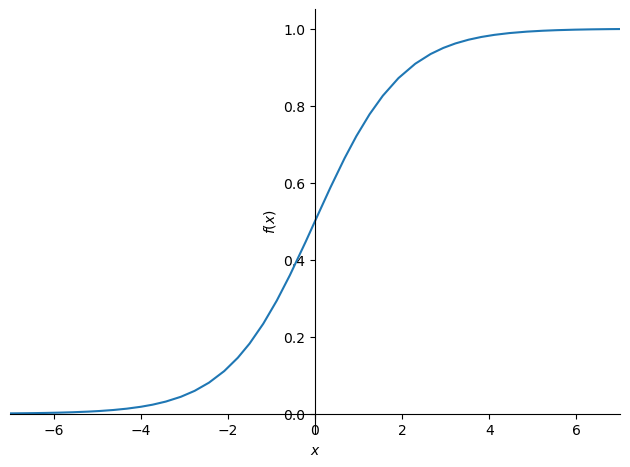

In [116]:
import sympy
sympy.plot('1/(1+exp(-x))', xlim=(-7,7));

In [117]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [118]:
coeffs = train_model(lr = 100)

0.524;0.291;0.211;0.203;0.199;0.198;0.198;0.197;0.197;0.196;0.196;0.196;0.196;0.195;0.195;0.195;0.195;0.195;0.195;0.195;0.195;0.195;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;

In [119]:
acc(coeffs)

tensor(0.8258)

In [120]:
show_coeffs()

{'Age': tensor(-0.4786),
 'SibSp': tensor(-0.0450),
 'Parch': tensor(0.1119),
 'LogFare': tensor(-0.2008),
 'Sex_male': tensor(-10.1734),
 'Sex_female': tensor(7.9806),
 'Pclass_1': tensor(3.3944),
 'Pclass_2': tensor(2.2695),
 'Pclass_3': tensor(-6.1976),
 'Embarked_C': tensor(1.4253),
 'Embarked_Q': tensor(2.1883),
 'Embarked_S': tensor(-5.0948)}

In [121]:
tst_df = pd.read_csv(path/'test.csv')

In [122]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [123]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [124]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [125]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [126]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


In [127]:
(val_indep*coeffs).sum(axis = 1)

tensor([ 12.4232, -14.1957, -14.9584, -13.0223, -13.0142, -13.0179,   3.1973,   5.1396, -21.4831,   3.1926, -21.4795, -14.9595, -21.4766,
          3.9582, -21.4787, -11.8943, -11.8958,   5.1395, -13.0186,  -3.3258, -21.4789, -11.8951,  12.7754,   5.1356, -21.4781, -14.2018,
         -3.3224, -11.8955, -21.4788,   3.9583,   5.1466,  -3.3303, -21.4785, -21.4794,  12.4228,  -3.3265, -11.8957,  12.7765, -21.4790,
         -3.3257, -13.0127, -21.4790, -13.0122,  12.7754, -21.4787,  -3.3184, -21.4886, -21.4836, -14.1952,  -3.3243,  -4.6187, -21.4837,
        -21.4810, -21.4784, -13.0132, -13.0137, -14.1957, -21.4837, -21.4787, -21.4826,  -5.3733, -21.4785, -11.8975, -21.4787,   5.1343,
        -11.8947, -13.0141, -21.4853, -14.1978,   5.1381, -21.4790,   3.1983, -13.0136, -21.4797, -11.8926, -21.4782, -21.4790, -11.9006,
        -13.0137, -13.0165, -13.0161,  12.7747, -21.4788, -21.4785,   5.1390,  -6.4943,  -5.3800,   6.2599,  11.6560, -13.0140, -21.4797,
        -21.4790,  12.7739, -14.95

In [128]:
val_indep@coeffs

tensor([ 12.4232, -14.1957, -14.9584, -13.0223, -13.0142, -13.0179,   3.1973,   5.1396, -21.4831,   3.1926, -21.4795, -14.9595, -21.4766,
          3.9582, -21.4787, -11.8943, -11.8958,   5.1395, -13.0186,  -3.3258, -21.4789, -11.8951,  12.7754,   5.1356, -21.4780, -14.2018,
         -3.3224, -11.8955, -21.4788,   3.9583,   5.1466,  -3.3303, -21.4785, -21.4794,  12.4228,  -3.3265, -11.8957,  12.7765, -21.4790,
         -3.3257, -13.0127, -21.4790, -13.0122,  12.7754, -21.4787,  -3.3184, -21.4886, -21.4836, -14.1952,  -3.3243,  -4.6187, -21.4837,
        -21.4810, -21.4784, -13.0132, -13.0137, -14.1957, -21.4837, -21.4787, -21.4826,  -5.3733, -21.4785, -11.8975, -21.4787,   5.1343,
        -11.8947, -13.0141, -21.4853, -14.1978,   5.1381, -21.4790,   3.1983, -13.0136, -21.4797, -11.8926, -21.4782, -21.4790, -11.9006,
        -13.0137, -13.0165, -13.0161,  12.7747, -21.4788, -21.4785,   5.1390,  -6.4943,  -5.3800,   6.2599,  11.6560, -13.0140, -21.4797,
        -21.4790,  12.7739, -14.95

In [129]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [130]:
def init_coeffs(): return (torch.rand(n_coeff, 1) * 0.1).requires_grad_()

In [131]:
trn_dep = trn_dep[:,None]
val_dedp = val_dep[:,None]

In [132]:
coeffs = train_model(lr = 100)

0.512;0.296;0.212;0.202;0.198;0.198;0.197;0.197;0.196;0.196;0.196;0.196;0.195;0.195;0.195;0.195;0.195;0.195;0.195;0.195;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;

In [133]:
acc(coeffs)

tensor(0.5429)

In [134]:
def init_coeffs(n_hidden = 20):
    layer1 = (torch.rand(n_coeff, n_hidden) - 0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1) - 0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [138]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [139]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [140]:
coeffs = train_model(lr = 1.4)

0.544;0.533;0.521;0.507;0.491;0.470;0.445;0.416;0.384;0.352;0.325;0.304;0.288;0.275;0.265;0.256;0.250;0.245;0.240;0.237;0.234;0.231;0.229;0.227;0.226;0.225;0.223;0.222;0.221;0.220;

In [141]:
coeffs = train_model(lr = 20)

0.544;0.416;0.256;0.311;0.212;0.200;0.198;0.197;0.196;0.195;0.194;0.194;0.194;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;0.193;

In [142]:
acc(coeffs)

tensor(0.5429)

In [144]:
def init_coeffs():
    hiddens = [10, 10]
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [145]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [146]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [147]:
coeffs = train_model(lr = 4)

0.526;0.483;0.464;0.378;0.373;0.361;0.346;0.356;0.304;0.214;0.209;0.207;0.210;0.202;0.203;0.202;0.204;0.198;0.196;0.195;0.195;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.193;0.193;

In [148]:
acc(coeffs)

tensor(0.5429)

## *Why you should use a framework*

In [1]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [4]:
df = pd.read_csv(path/'train.csv')

In [6]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A = 'ABC', B = 'ABC', C = 'ABC', D = 'DE', E = 'DE', F = 'FG', G = 'FG'))
    df['Family'] = df.SibSp + df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand = True)[1].str.split('.', expand = True)[0]
    df['Title'] = df.Title.map(dict(Mr = 'Mr', Miss = 'Miss', Mrs = 'Mrs', Master = 'Master'))
    
add_features(df)

In [7]:
splits = RandomSplitter(seed = 42)(df)

In [8]:
dls = TabularPandas(
    df, splits = splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names = ['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'],
    cont_names = ['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names = 'Survived', y_block = CategoryBlock(),
).dataloaders(path = '.')

In [9]:
learn = tabular_learner(dls, metrics = accuracy, layers = [10, 10])

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

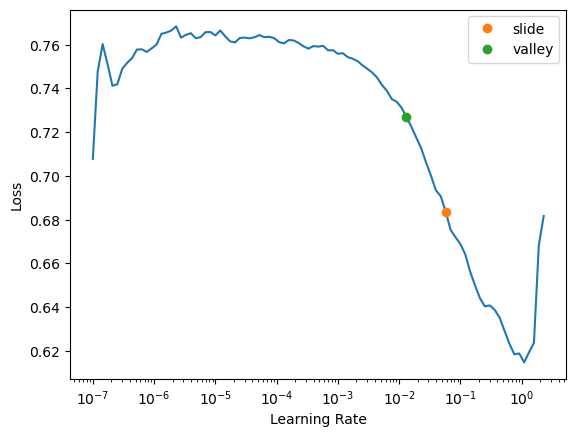

In [10]:
learn.lr_find(suggest_funcs = (slide, valley))

In [11]:
learn.fit(16, lr = 0.03)

epoch     train_loss  valid_loss  accuracy  time    
0         0.577146    0.582949    0.606742  00:00                                         
1         0.510818    0.498523    0.786517  00:00                                         
2         0.467023    0.459841    0.797753  00:00                                         
3         0.439957    0.468547    0.797753  00:00                                         
4         0.427232    0.415261    0.825843  00:00                                         
5         0.416340    0.437362    0.820225  00:00                                         
6         0.408347    0.413253    0.848315  00:00                                         
7         0.400442    0.406075    0.803371  00:00                                         
8         0.397265    0.443730    0.820225  00:00                                         
9         0.392389    0.432267    0.831461  00:00                                          
10        0.389983    0.415383    0.

In [12]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [13]:
tst_dl = learn.dls.test_dl(tst_df)

In [14]:
preds,_ = learn.get_preds(dl = tst_dl)

In [16]:
tst_df['Survived'] = (preds[:,1] > 0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('sub.csv', index = False)

In [17]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## *Ensembling*

In [18]:
def ensemble():
    learn = tabular_learner(dls, metrics = accuracy, layers = [10,10])
    with learn.no_bar(), learn.no_logging(): learn.fit(16, lr = 0.03)
    return learn.get_preds(dl = tst_dl)[0]

In [19]:
learns = [ensemble() for _ in range(5)]

In [20]:
ens_preds = torch.stack(learns).mean(0)

In [21]:
tst_df['Survived'] = (ens_preds[:,1] > 0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('ens_sub.csv', index = False)

## *How random forests really work*

In [22]:
from fastai.imports import *
np.set_printoptions(linewidth = 130)

In [23]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [24]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [25]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [26]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [27]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

## *Binary splits*

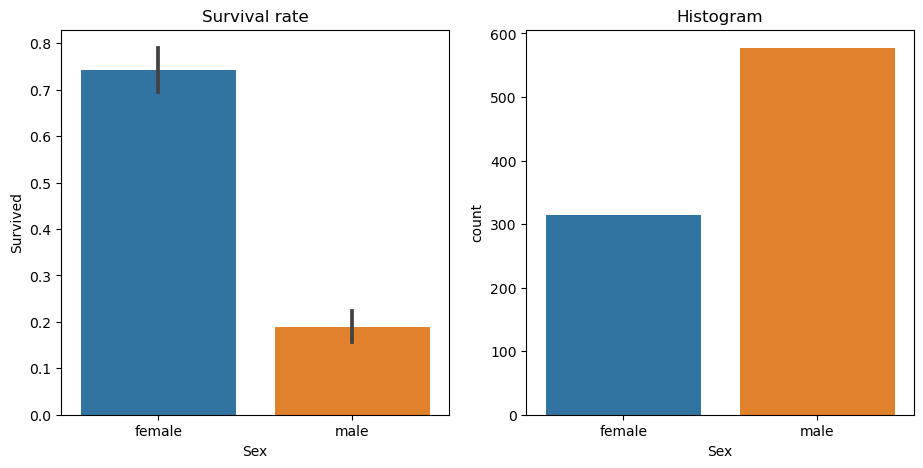

In [29]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [30]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [31]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [32]:
preds = val_xs.Sex==0

In [33]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

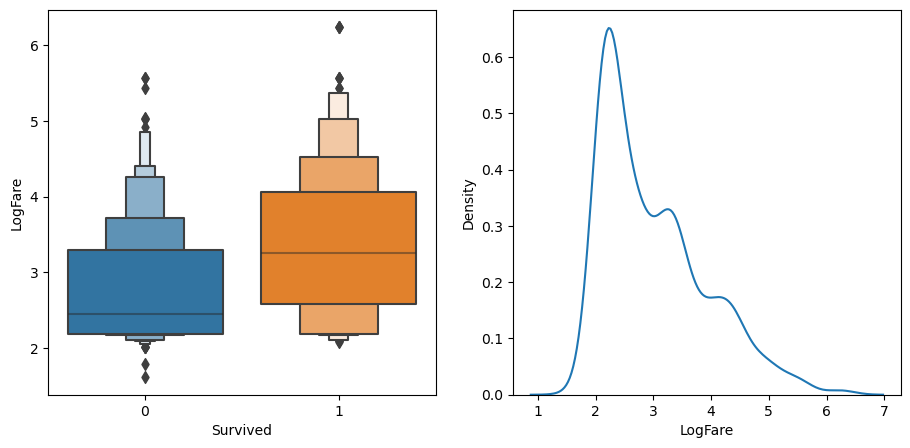

In [34]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

In [35]:
preds = val_xs.LogFare>2.7

In [36]:
mean_absolute_error(val_y, preds)

0.336322869955157

In [37]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [38]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [39]:
score(trn_xs["Sex"], trn_y, 0.5)

0.40787530982063946

In [40]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

In [41]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [42]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

In [43]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [44]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

In [45]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.478316717508991)

In [46]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}